# Time Series Analysis of Google Trends Data for Chipotle
### This analysis was performed to see if advertising spend has an effect on the volume of google searches for Chipotle

In [1]:
from search_sampler import SearchSampler
import pandas as pd
from fbprophet import Prophet
import numpy as np
import holidays
from datetime import date
from statsmodels.tsa import stattools
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.dates as mdates
from statsmodels.tsa import seasonal

Set the parameters for the Google search data. We want all Google searches for Chipotle in the United States between October 7, 2013 and October 1, 2018 by day.

In [2]:
search_name = 'chipotle'

params = {
    'search_term':['/m/01b566'],
    'region':'US',
    'period_start':'2013-10-07',
    'period_end':'2018-10-01',
    'period_length':'day'
}

Using the Google Trends API, we create a dataframe that shows the number of Google searches for Chipotle by day. Then change the period column into proper date format for analysis

In [4]:
sample = SearchSampler(apikey, search_name, params)
allsearches = sample.pull_data_from_api()
chipotle = allsearches['/m/01b566']
chipotle['period'] = chipotle['period'].dt.date

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

INFO: Running period 2013-10-07 - 2018-10-01


Create a simple plot showing volume of Google searches for Chipotle over time. There doesn't seem to be any linear trends on first glance. 

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


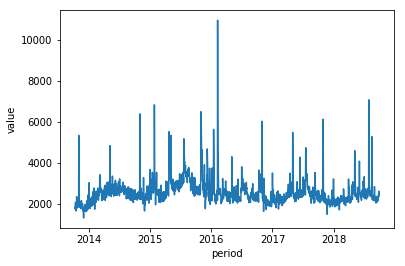

In [5]:
chipotleplot = sns.lineplot(x = 'period', y = 'value', data = chipotle)

Create a new column in our dataframe called "onediffvalue" that takes the difference in volume of Google searches from the day before. 

In [6]:
chipotle['onediffvalue'] = chipotle['value'].diff(1)

Perform an ADF test to test stationarity. The values are very small and pass our test.

In [7]:
adf_result_value = stattools.adfuller(chipotle['value'])
adf_result_onediffvalue = stattools.adfuller(chipotle['onediffvalue'].iloc[1:])

print(adf_result_value[1])
print(adf_result_onediffvalue[1])

5.276651090860392e-15
4.183683990691111e-24


Create a simple plot showing volume of Google searches for Chipotle over time, only this time using 'onediffvalue' instead of 'value'.

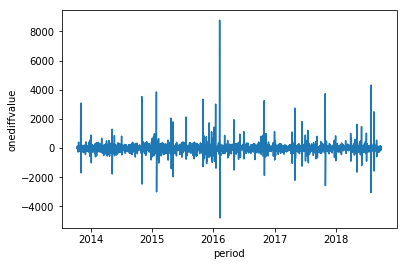

In [8]:
chipotleplot = sns.lineplot(x = 'period', y = 'onediffvalue', data = chipotle)

Make another plot to show volume of Google searches over time. We can see a bit more clearly with this one when the searches are going up and down. It still isn't showing any trends or anything of significant value from a business standpoint.

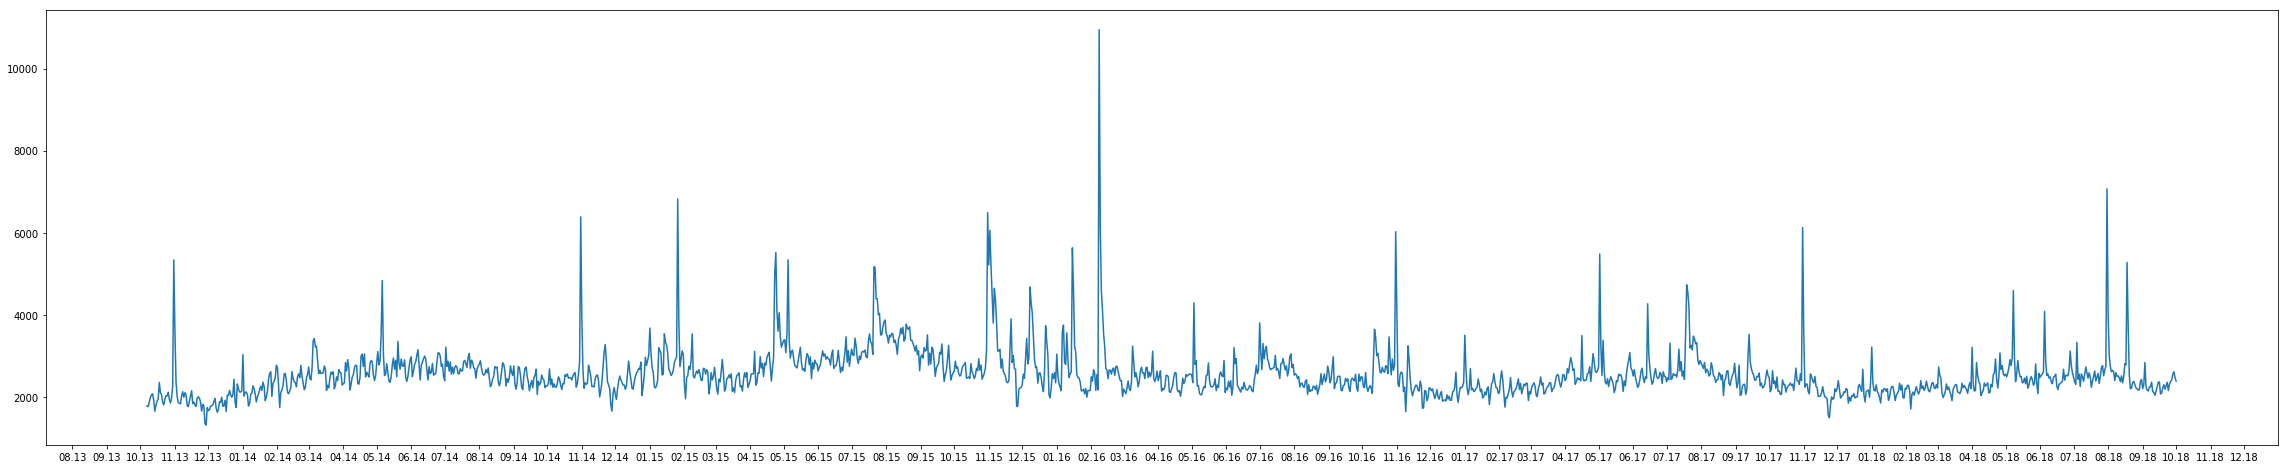

In [9]:
chipotle.set_index('period', inplace = True)

dimensions = (40, 8)
fig, ax = pyplot.subplots(figsize = dimensions)

years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)

ax.plot(chipotle.index, chipotle['value'])

### Decompose Model

Next, we create a decompose model to evaluate seasonality. The first graph is the same graph we just created above that displays volume of Google searches. I'm putting it here again to analyze it next to the other graphs. 

The second graph shows the overall trend in Google searches. Search volume has significantly decreased since the end of 2015 to the beginning of 2016. It steadily decreased from the end of 2015 to about midway through 2016 and has steadily remained low. This could be for a variety of reasons. Chipotle may be in the news less often, causing users to search for them less often. They also could have decreased advertising spend. This is something we will analyze later. 

The third graph is displaying seasonality to determine if there are any seasonal trends in our data. The most significant trend seen off first look is the five big spikes that appear to show up within the last few months of each year. One thing that Chipotle is known for is giving out buy one get one free burritos on Halloween if you wear a costume to the restaurant. This may be a reason why people are searching for Chipotle on Google. 

The final plot is a residual plot, or a plot that shows how well our predictions match the actual values. We see a lot of spikes scattered throughout a fair amount of steady lines. This means that there are other factors than seasonality that are affecting Google searches for Chipotle. 

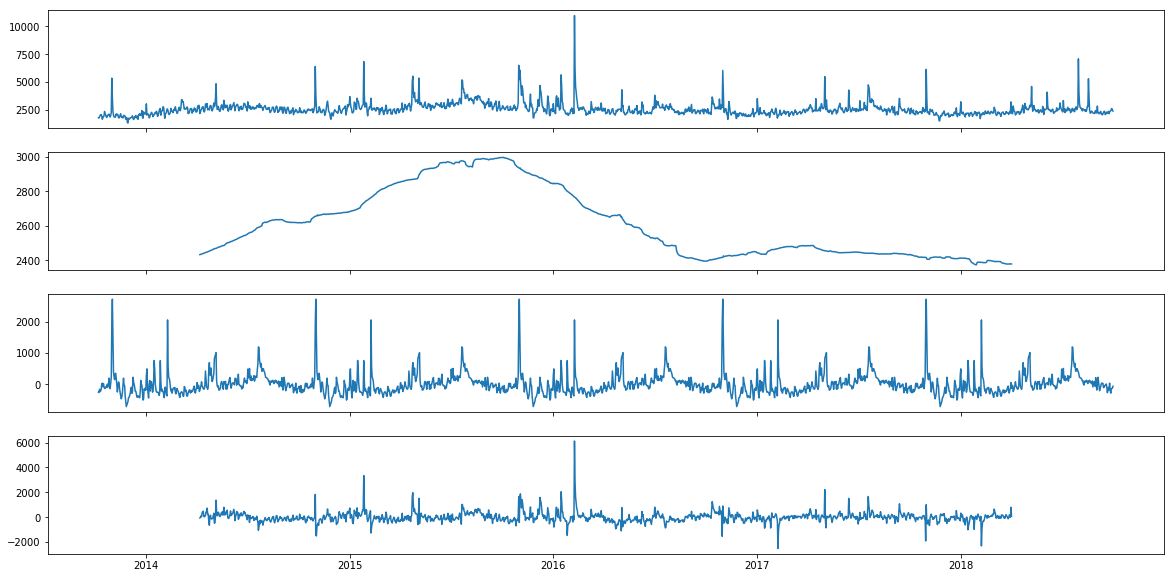

In [10]:
decompose_model = seasonal.seasonal_decompose(chipotle['value'].tolist(), freq = 365, model = 'additive')

dimensions = (20, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize = dimensions, sharex = 'all')

ax1.plot(chipotle.index, chipotle['value'])
ax2.plot(chipotle.index, decompose_model.trend)
ax3.plot(chipotle.index, decompose_model.seasonal)
ax4.plot(chipotle.index, decompose_model.resid)

### Seasonality
Here's a more in-depth look at seasonality based only off the year 2015. There seem to be four spikes appearing in February, May, August, and end of October/early November. As stated earlier, the largest spike appears right at the end of OCtober when Chipotle does it's annual buy one get one free Halloween deal. The other spikes in data may be driven by outside or unpredictable factors. It will take further analysis and research to determine this.

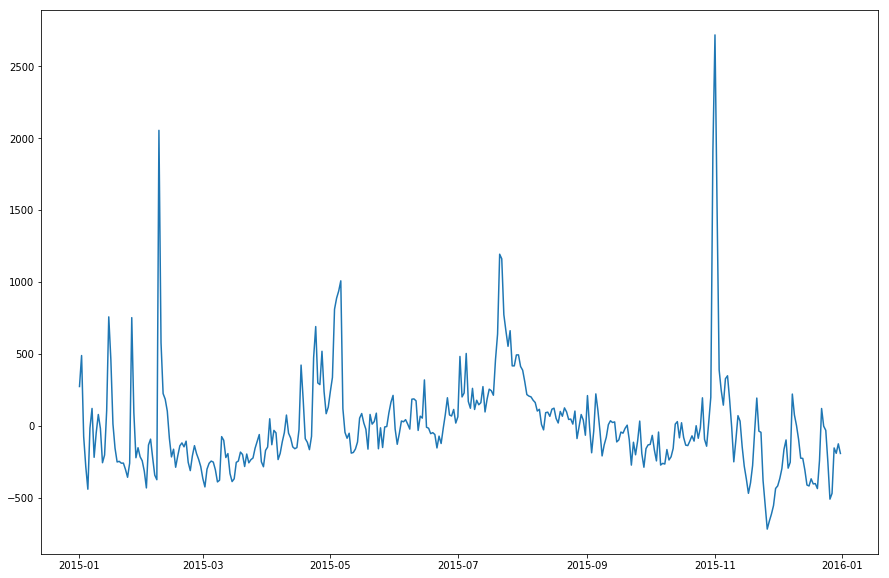

In [11]:
chipotle['seasonal'] = decompose_model.seasonal

startdate = pd.to_datetime("2015-01-01").date()
enddate = pd.to_datetime("2015-12-31").date()

oneyear = chipotle.loc[startdate:enddate]

dimensions = (15, 10)
fig, ax1 = pyplot.subplots(figsize = dimensions)

pyplot.plot(oneyear.index, oneyear.seasonal)

In [12]:
chipotle = pd.read_csv("chipotle_googletrends.csv", parse_dates = ['period'])

In [13]:
prophetdataframe = pd.DataFrame()

prophetdataframe['ds']= chipotle['period'] 
prophetdataframe['y'] = chipotle['value']

### Forecasting
Create a prophet dataframe to predict Google search data in the next calendar year. The new 'forecast' dataframe is a prediction in Google trends data for the next 365 days based on the data from the past five years we've been using.

In [14]:
m = Prophet()
m.fit(prophetdataframe)

future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Below are the last five days of our forecast prediction. Column "yhat" is the predicted volume of Google searches for that day. "yhat_lower" and "yhat_upper" give us a 95% confidence interval of Google searches for Chipotle that day. It seems to be a fairly wide range.

In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2181,2019-09-27,2378.511415,1688.425219,3020.454253,2116.536377,2649.141802,-38.761716,-38.761716,-38.761716,101.905366,101.905366,101.905366,-140.667082,-140.667082,-140.667082,0.0,0.0,0.0,2339.749699
2182,2019-09-28,2378.452928,1583.935729,2904.946844,2115.545083,2649.926873,-103.547198,-103.547198,-103.547198,56.325515,56.325515,56.325515,-159.872713,-159.872713,-159.872713,0.0,0.0,0.0,2274.905730
2183,2019-09-29,2378.394440,1486.131483,2914.246606,2114.286187,2650.711944,-187.462921,-187.462921,-187.462921,-7.938001,-7.938001,-7.938001,-179.524920,-179.524920,-179.524920,0.0,0.0,0.0,2190.931520
2184,2019-09-30,2378.335953,1407.340158,2777.847715,2112.837166,2651.497015,-293.404432,-293.404432,-293.404432,-94.264210,-94.264210,-94.264210,-199.140222,-199.140222,-199.140222,0.0,0.0,0.0,2084.931521
2185,2019-10-01,2378.277465,1402.831072,2810.550284,2111.388146,2652.272524,-259.828274,-259.828274,-259.828274,-41.627573,-41.627573,-41.627573,-218.200701,-218.200701,-218.200701,0.0,0.0,0.0,2118.449191


Below is a plot of our forecast. The black points are the actual values from our data. The dark blue is the error in our prediction. The light blue gives a 95% confidence interval for our prediction. There are a lot of values that fall outside of the light blue area, meaning we have a lot of outliers in our data. There doesn't seem to be any pattern on when the outliers fall either. This means that seasonality may not be significant for Google searches of Chipotle. This means there are other factors that are affecting general interest in Chipotle. My hypothesis is that Chipotle has been in the news multiple times over the past few years for disease-related stories where people get very sick from eating at their restaraunt. Every time this happens it makes national news. This, among other things, may be an indicator of when public interest in Chipotle increases. 

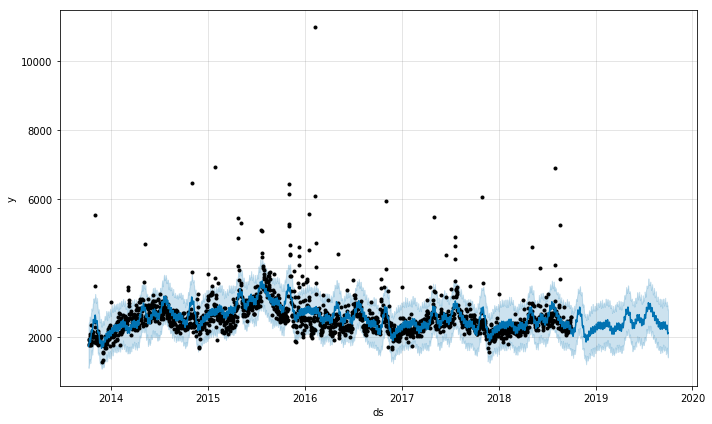

In [16]:
fig1 = m.plot(forecast)

Here are the overall, weekly, and yearly trends in our data. Chipotle interest peaked in 2015 and declined throughout 2016. It's remained on a slightly negative, but somewhat steady, trend since mid-2016. On a weekly basis, interest seems to be the most high on weekends. As a restaraunt, this isn't too surprising. According to a Gallup report, consumers spend more on dining out on weekends versus weekdays. The final graph shows our predicted monthly trend. We expect to see the largest spikes in May, August, and October. October can probably be explained by Chipotle's annual Halloween deal. Later, we'll include Halloween in our model to see if it will improve accuracy. 

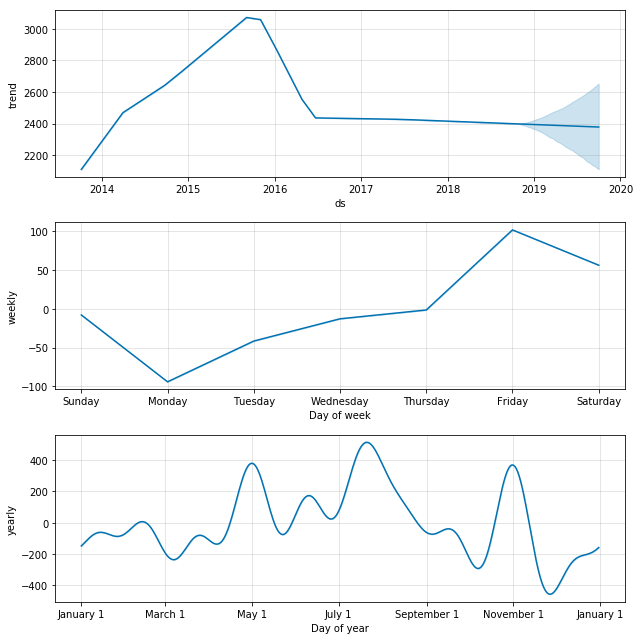

In [17]:
fig2 = m.plot_components(forecast)

I'd like to take a closer look at the total error and average error of our model. The first value below is our total error and the second value is our average error. This means that for our prediction, we were off from the actual value by an average of 269.  

In [18]:
erroranalytics = m.predict(prophetdataframe)

erroranalytics['value'] = prophetdataframe['y']
erroranalytics['residuals'] = erroranalytics['value'] - erroranalytics['yhat']
erroranalytics['absoluteresidual'] = abs(erroranalytics['residuals'])

totalerror = erroranalytics['absoluteresidual'].sum()

print(totalerror)
print(totalerror/len(erroranalytics))

490067.35896126647
269.1199115657696


Now we want to see if any holidays have an effect on interest in Chipotle. The only holiday that Chipotle regularly has any specials on is Halloween. I'm including Halloween as a factor in our analysis. 

In [36]:
sales = pd.DataFrame(columns = ['holiday', 'ds', 'lower_window', 'upper_window'])

halloween = pd.DataFrame({
    'holiday': 'halloween',
    'ds': pd.to_datetime(['2013-10-31', '2014-10-31', '2015-10-31', '2016-10-31', '2017-10-31', '2018-10-31']),
    'lower_window': -4,
      'upper_window': 0,
})
sales = pd.concat((sales, halloween))

In [37]:
chipotle = pd.read_csv('chipotle_googletrends.csv', parse_dates = ['period'])

In [38]:
prophetdataframe = pd.DataFrame()
prophetdataframe['ds']= chipotle['period'] 
prophetdataframe['y'] = chipotle['value']

In [39]:
prophetdataframe.head()

,ds,y
0,2013-10-07,1777.488674
1,2013-10-08,1753.292767
2,2013-10-09,1920.502595
3,2013-10-10,1930.256497
4,2013-10-11,2019.618211


Now we want to include in our model the holidays with sales. In this case, it's only Halloween.

In [40]:
m = Prophet(holidays=sales)
m.fit(prophetdataframe)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

In our new residual plot, we can see that the dark blue section indicating error now peaks on each Halloween and captures some, but not all, of the outliers in the data. This should give our model a better overall fit and result in a smaller error.

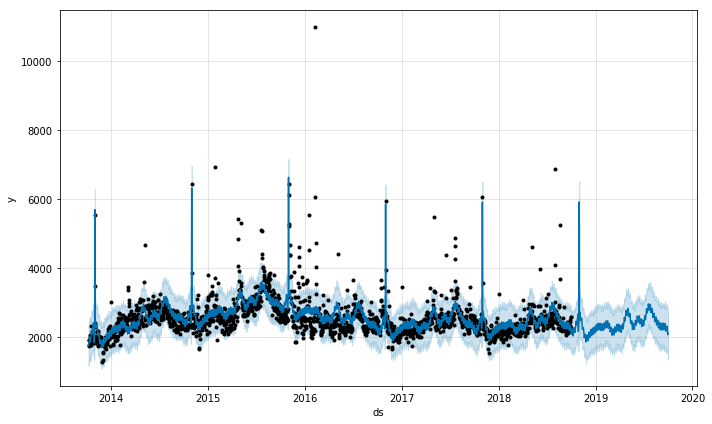

In [42]:
fig1 = m.plot(forecast)

In [43]:
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresidual'] = abs(erroranalysis['residuals'])

Here, we can see that we decreased our average error by about 14 by including Halloween as a factor in our model.

In [45]:
totalerror = erroranalysis['absoluteresidual'].sum()
print(totalerror/len(erroranalysis))

254.922828619603


There's still many outliers in our data that the model doesn't capture. The following output shows us the 10 days with the highest residuals, meaning what were the 10 days where the actual Google trends data was furthest from our prediction? February 8th, 2016 has nearly double the residual value of the next largest day. On this day, Chipotle shut down their stores nationwide amid E. coli and salmonela outbreaks to hold a food safety meeting with all employees.  The day with the next highest residual, January 26th, 2016, Chipotle was offering buy one get one free burritos to promote their new vegetarian protein. The next day down the list, July 31st, 2018, Chipotle was giving away free guacamole for Avocado day. We see a trend here. If Chipotle is offering a deal, people are going to be interested. 

In [50]:
print(erroranalysis.nlargest(10, 'absoluteresidual'))

             ds        trend   yhat_lower   yhat_upper  trend_lower  \
854  2016-02-08  2792.168392  2083.897338  3308.635151  2792.168392   
476  2015-01-26  2786.923882  2016.791506  3186.530647  2786.923882   
1758 2018-07-31  2392.822403  2190.083634  3290.438852  2392.822403   
855  2016-02-09  2789.168824  2185.374697  3302.773156  2789.168824   
756  2015-11-02  3039.729794  2603.946001  3771.079338  3039.729794   
1303 2017-05-02  2429.455746  2168.120173  3350.290476  2429.455746   
1776 2018-08-18  2391.172269  1987.027536  3123.312748  2391.172269   
830  2016-01-15  2864.158009  2339.019340  3445.760851  2864.158009   
564  2015-04-24  2892.392582  2668.299517  3859.874487  2892.392582   
575  2015-05-05  2905.576359  2602.367222  3758.519746  2905.576359   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
854   2792.168392     -105.137831           -105.137831           -105.137831   
476   2786.923882     -183.897619           -183.897619 

### Does advertising expenditure have an effect on our data?
Many organizations spend tons of money on advertising with difficulty in knowing if it's actually working. Here, we're going to compare our Google trends data with Chipotle's advertising expenditure to see if there is a relationship, i.e., do people search for Chipotle on Google more if they spend more on advertising?

Below, we are importing a csv file that contains Chipotle's advertising spending on different mediums and formatting it for analysis.

In [53]:
adspend= pd.read_csv('chipotle.adspend.csv')
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF ", "", regex=True)
adspend['TIME PERIOD'] = adspend["TIME PERIOD"].str.replace(" \(B\)", "", regex = True)
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "", regex = True)
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])
adspend_no_product = adspend.pivot_table(index = 'FIXED TIME', aggfunc = np.sum)

Chipotle spends their advertising money almost exclusively on cable tv, national spot radio, outdoor, and magazines. The following four graphs show spending in each of these four categories. They only began advertising on Cable TV in 2017. Right when they began spending more on Cable, their spend on radio and magazines went way down. Outdoor spending peaked around 2016 but has slowly decreased since then. 

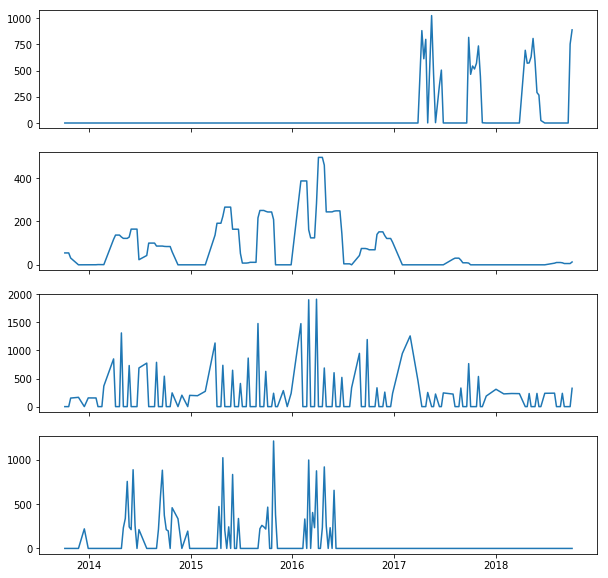

In [55]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize = dimensions, sharex = 'all')

ax1.plot(adspend_no_product.index, adspend_no_product['CABLE TV'])
ax2.plot(adspend_no_product.index, adspend_no_product['NAT SPOT RADIO'])
ax3.plot(adspend_no_product.index, adspend_no_product['OUTDOOR'])
ax4.plot(adspend_no_product.index, adspend_no_product['MAGAZINES'])

Next, we're getting ready to merge our Chipotle Google trends data with our ad spend data.

In [56]:
testdate = pd.to_datetime("2013-10-07")
chipotle = pd.read_csv('chipotle_googletrends.csv', parse_dates = ['period'])
chipotle.set_index('period', inplace = True)
chipotle_weekly = chipotle.resample('W-MON', closed = 'left', label = 'left').mean()

In [57]:
merge_weekly = adspend_no_product.join(chipotle_weekly)

The top graph is showing advertising expenditure while the bottom graph is showing Google trends data. It is unclear at this point if there's a relationship. They don't seem to fluctuate at the same time. 

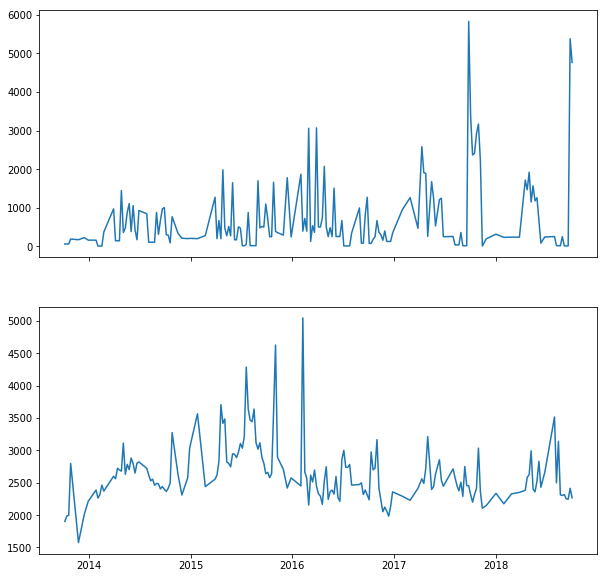

In [58]:
dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex='all')
ax1.plot(merge_weekly.index, merge_weekly['TOTAL'])
ax2.plot(merge_weekly.index, merge_weekly['value'])

Let's take a look at the correlation. Just like we predicted from the graphs, there's no immediate correlation between ad spend and Google searches. 

In [61]:
merge_weekly['totaldiff'] = merge_weekly['TOTAL'].diff(1)
merge_weekly['valuediff'] = merge_weekly['value'].diff(1)

print(merge_weekly['TOTAL'].corr(merge_weekly['value']))
print(merge_weekly['totaldiff'].corr(merge_weekly['valuediff']))

-0.07816773839224177
-0.08928622349344047


In [64]:
adspend_trends = pd.read_csv("chipotle_weekly_adspend.csv", parse_dates = ["FIXED TIME"])
adspend_trends.set_index("FIXED TIME", inplace = True)
adspend_trends = adspend_trends.drop(columns = ['onediffvalue', 'Unnamed: 0', 'totaldiff', 'valuediff'])

We need to perform an ADF test to see if our ad spend data is stationary. It is not, so we can't do a time series analysis in it's current state. 

In [65]:
for acolumn in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    print(adf_result[1])

0.7149015416847396
0.0003476521042375153
0.3244689989481361
3.852658416229987e-12
4.288604416460474e-05
3.6995114334025364e-25
3.3778211488623325e-07
0.0004043517531728217
1.5072446229614715e-05
0.035667319576622676


Here, we create a new dataframe to take the difference in advertising expenditure from the week before in hopes of making our data stationary. By running another ADF test on our new data, we find that it is indeed stationary. 

In [66]:
adspend_trends_diff = pd.DataFrame()

for acolumn in list(adspend_trends):
    columnname = "%s diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1)

for acolumn in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:])
    print(adf_result[1])

5.6187663503487845e-09
1.5297819689260008e-09
3.928421443282114e-05
2.1872765732855514e-12
8.555604173426525e-05
3.848321645070926e-13
4.495159433538989e-10
5.518959681844407e-09
3.2963435163546146e-08
3.6882036165689367e-19


According to our prediction from earlier, spending money on advertising overall doesn't have any correlation with Google trends data. It may be worth it to look into each individual medium of advertising to see if a single one does. It turns out that none do. Network TV is the only medium that has over 1% correlation with Google trends. Although there is no correlation, that is a significant finding in itself for Chipotle. Maybe they don't need to be spending as much as they do on advertising. People become interested if Chipotle is in the news or they're having any special deals. As a fast-casual restaraunt, this isn't too surprising. Most people know what Chipotle is and probably have one somewhere near where they live. It's unlikely that your regular run-of-the-mill Chipotle ad will cause someone to become more interested. 

CABLE TV diff -0.03766835565231878
MAGAZINES diff -0.016358757341515803
NAT SPOT RADIO diff -0.08241772988835613
NATL NEWSP diff -0.07138033670074626
NETWORK TV diff 0.011535108647737349
NEWSPAPER diff -0.05417603947586389
OUTDOOR diff -0.12383628350965953
SPOT TV diff 0.0035518559658870206
TOTAL diff -0.08928622349344063


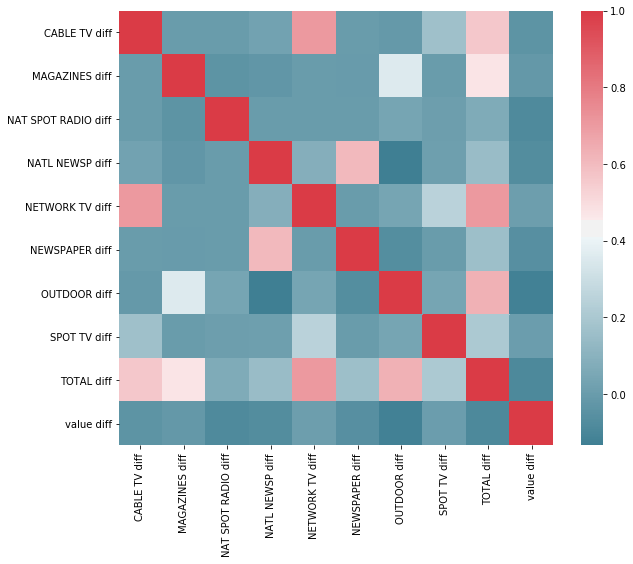

In [68]:
corrlist = []
for acolumn in list(adspend_trends_diff):
    if "value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff['value diff'])
        print(acolumn, corr)
        corrlist.append(corr)

f, ax = pyplot.subplots(figsize = (10, 8))
corr = adspend_trends_diff.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
           square = True, ax = ax)